# Feature Engineering

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

In [58]:
# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns
# from ggplot import *
from beautifultable import BeautifulTable
# ignore the warning
import warnings

In [3]:
# for feature engineering
import time
import datetime
import scipy.stats

### Load Data

In [36]:
data = pd.read_feather(cleaned_bid)
data.head()

,Unnamed: 0,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
0,0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3
1,1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3
2,2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3
3,3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3
4,4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3


## Feature Creation

In [83]:
def ent(data):
    """
    Calculate the entropy

    Parameters
    ----------
    data : dataframe
        a DataFrame containing original data

    Returns
    -------
    output: float
        computed entropy 

    Notes
    -----
    entropy is calculated with the following steps:
        1. compute the probabilities
        2. fit in the entropy formula
    """
    p_data = data.value_counts()/len(data)  # calculates the probabilities
    # input probabilities to get the entropy
    entropy = scipy.stats.entropy(p_data)
    return entropy

In [41]:
# bidding time difference per user (bidder_id)
bid = bid.sort_values(by=['time'])
bid['timediffs'] = bid.groupby('bidder_id')['time'].transform(pd.Series.diff)

# number of bids a user made per auction
bids_per_auction = bid.groupby(['auction', 'bidder_id']).size()
bids_per_auction = bids_per_auction.to_frame()

# proportion of bots for each country
pbots_country = bid[bid['outcome'] == 1].groupby(
    'country').size()/bid.groupby('country').size()
pbots_country = pbots_country.fillna(0)
pbots_country = pbots_country.to_frame()

# proportion of bots per device
pbots_device = bid[bid['outcome'] == 1].groupby(
    'device').size()/bid.groupby('device').size()
pbots_device = pbots_device.fillna(0)
pbots_device = pbots_device.to_frame()

# number of unique ip to number of bids ratio
ip_bids_ratio = bid.groupby('bidder_id')['ip'].nunique(
)/bid.groupby('bidder_id')['bid_id'].nunique()
ip_bids_ratio = ip_bids_ratio.to_frame()

# mean per auction url entropy for each user
# Input a pandas series
auction_url_entropy = bid.groupby(['auction', 'bidder_id'])['url'].apply(ent)
auction_url_entropy = auction_url_entropy.groupby(
    'bidder_id').mean().reset_index()

In [42]:
# merge the features back
bid = pd.merge(bid, bids_per_auction, on=['auction', 'bidder_id'], how='left')
bid = pd.merge(bid, pbots_country, on='country', how='left')
bid = pd.merge(bid, pbots_device, on='device', how='left')
bid = pd.merge(bid, ip_bids_ratio, on='bidder_id', how='left')
bid = pd.merge(bid, auction_url_entropy, on='bidder_id', how='left')
# set column names
bid.columns = ['Unnamed: 0', 'bidder_id', 'payment_account', 'address', 'outcome',
               'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
               'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device',
               'ip_bids_ratio', 'auction_url_entropy']

In [43]:
bid = pd.concat([bid.iloc[:, 4], bid.iloc[:, -6:]], axis=1)

In [44]:
bid.to_csv("featured.csv")

In [52]:
bid = pd.read_csv("featured.csv")
bid = bid.iloc[:, 1:8]

## Data visualization

Check whether the new features could help us identify human and robots, plot the distribution of each feature of two different type of bidders.

In [59]:
warnings.filterwarnings('ignore')

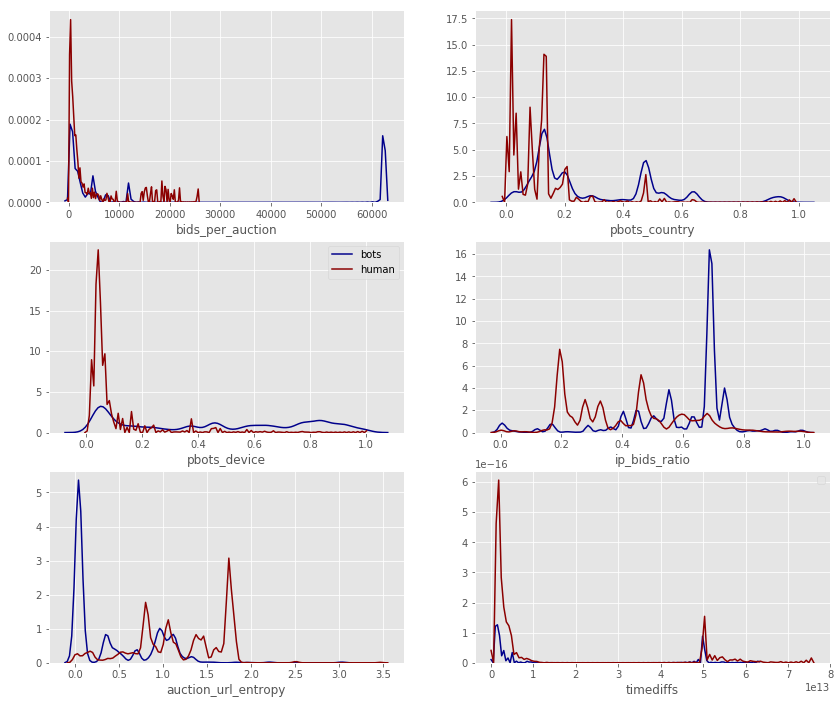

In [60]:
bots = bid.loc[bid.outcome == 1]
human = bid.loc[bid.outcome == 0]

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
sns.distplot(bots['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

sns.distplot(bots['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

sns.distplot(bots['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkblue', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkred', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

sns.distplot(bots['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

sns.distplot(bots['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

sns.distplot(bots['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
plt.legend(['bots', 'human'])
plt.show()

Since the variable `timediff` (time differ per user) showed a similar distribution between robots and human. It also has  no clearly correlation with our outcome. Therefore, this variable may not be very helpful when we are fitting a model. In contrast, we may even have overfitting problems if we incorporate it in our models. Therefore, we will ignore the variable `timediff` during the modeling process.

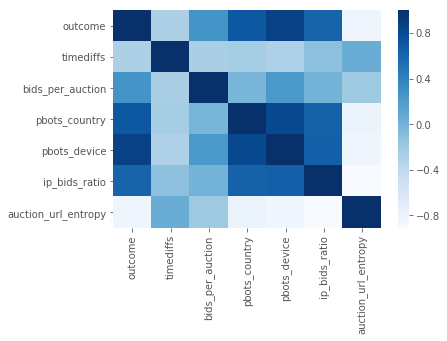

In [54]:
# Plot the correlation matrix for the numerical values
corr_matrix = bid.corr()
sns.heatmap(corr_matrix.corr(),
            xticklabels=corr_matrix.corr().columns,
            yticklabels=corr_matrix.corr().columns,
            cmap="Blues",
            fmt='d')

This plot is  the correlation matrix heatmap for our engineered features.  Dark blue in this heatmap means two variables  are highly positively correlated with each other. The white color in this heatmap indicates that two features are highly negatively correlated with each other.  From this plot, we can infer that proportion of bots per device, proportion of bots for each country and  number of unique ip to number of bids ratio are highly positively correlated with our outcome. While the mean per auction url entropy for each user are highly negatively correlated with our outcome. However, the variable time differ per user does not show clearly corrrelation with our outcome.